<h1 align='center'> Time Series Experiments </h1>

In this notebook with the help of nixtla we will implement all the models we have discussed about on our previous documents.

Algorithms to try out: 

In [23]:
import prophet
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator,YearLocator
import pandas as pd

<h3> Data Checking out </h3>

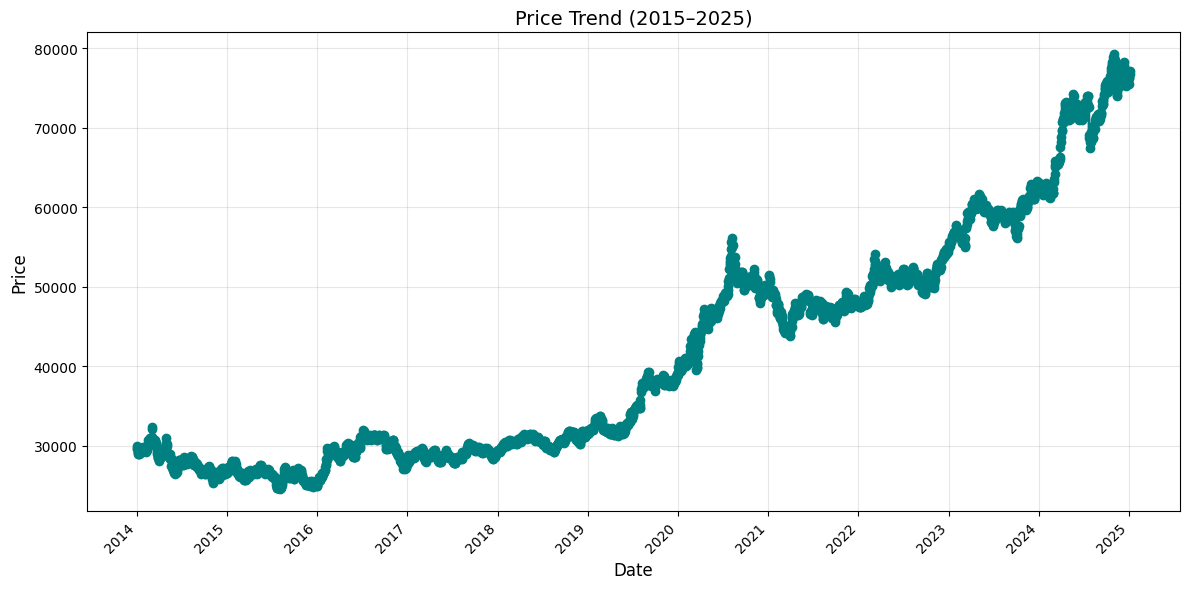

In [ ]:
df=pd.read_csv('Gold Price.csv')

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # ensure datetime conversion

display(df[['Date','Price']])
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'], marker='o', color='teal', linewidth=2)

ax = plt.gca()
ax.xaxis.set_major_locator(YearLocator(1))  # tick every year
ax.xaxis.set_major_formatter(DateFormatter("%Y"))  # format as 2015, 2016, etc.

plt.gcf().autofmt_xdate(rotation=45)  # rotate date labels for readability
plt.title("Price Trend (2015–2025)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()